# Présentation Challenge Tuxae 2024
Le robot est une base différentielle, c'est à dire munie de deux roues motrices indépendantes. Pour aller tout droit les deux roues tournent dans le même sens à la même vitesse et pour tourner les roues tournent à vitesse différentes ou dans le sens opposé.   
L'objectif est d'estimer les trois valeures $(x, y, \alpha)$  

[https://github.com/Tuxae/ChallengeTuxae2024/](https://github.com/Tuxae/ChallengeTuxae2024/)

In [9]:
import pandas as pd
import numpy as np
from math import pi

In [10]:
df = pd.read_csv("train/ligne_droite.csv", index_col=0)
df

vx        vy       vrz      rot_g      rot_d    image         x  \
0  0.000000  0.000066  0.000000   0.000000   0.000000  000.png  0.225000   
1  0.153246 -0.000810  0.002323   3.120053  -3.123415  001.png  0.384353   
2  0.078835  0.002848  0.052618   4.612360  -4.632692  002.png  0.463322   
3  0.076039  0.000219  0.028701   6.091170  -6.122394  003.png  0.540326   
4  0.073199 -0.001382  0.050622   7.573777  -7.608174  004.png  0.617558   
5  0.078475  0.001987  0.017367   9.042129  -9.084502  005.png  0.694769   
6  0.080799  0.008261 -0.015809  10.496015 -10.562298  006.png  0.771367   
7  0.075678  0.006131 -0.007040  11.923313 -12.067926  007.png  0.848890   
8  0.073962  0.006299  0.030275  13.404095 -13.677770  008.png  0.925447   
9  0.078925  0.007407  0.032343  14.777149 -15.237526  009.png  1.003509   

          y     alpha  
0  0.225001 -0.000000  
1  0.225073  0.000785  
2  0.225617  0.019998  
3  0.226755  0.037680  
4  0.228448  0.052976  
5  0.231400  0.069524  
6  0.234786  0.087318  
7  0.240449  0.101844  
8  0.243839  0.130543  
9  0.251151  0.154558

L'objectif est donc d'estimer les 3 dernières colonnes $(x, y, \alpha)$ à partir des autres colonnes. On a également accès à la caméra et le robot se déplace sur un plateau de $3m\times 2m$. La position de départ du robot est $(0.225,0.225, 0)$ en (mètre, mètre, radian).


$indice$ est la seconde à laquelle la mesure a été faite (une mesure est faite toutes les secondes).    <br>
$vx$ et $vy$ sont les vitesses en m/s sur les axes respectifs $x$ et $y$.     <br>
$vrz$ est la vitesse de rotation en rad/s autour de l'axe $z$.    <br>
$rot\_g$ et $rot\_g$ sont l'angle en rad du moteur respectivement gauche et droit.    <br>
$image$ est le nom du fichier image.    <br>

## Une idée simple d'intégration

In [11]:
df_est = df[['vx', 'vy', 'vrz', 'rot_g', 'rot_d', 'image']]
df_est.loc[:, ["alpha"]] = 0.0
df_est.loc[:, ["x", "y"]] = 0.225
n = len(df_est)
for i in range(n-1):
    df_est.at[i+1, "x"] = df_est.at[i, "x"] + df_est.at[i, "vx"]
    df_est.at[i+1, "y"] = df_est.at[i, "y"] + df_est.at[i, "vy"]
    df_est.at[i+1, "alpha"] = df_est.at[i, "alpha"] + df_est.at[i, "vrz"]

In [12]:
def score(df, df_est):
    df = df[['x', 'y', 'alpha']]
    df_est = df_est[['x', 'y', 'alpha']]
    result = abs(df-df_est)
    result["alpha"] = result["alpha"] % pi
    result = result / (3, 2, pi)
    return 1-result.mean().mean()
    
print(f"Le score est de {round(score(df, df_est)*100, 2)} %")


Le score est de 98.77 %


In [13]:
# N'oubliez pas de renommer la colonne d'indice "ID" et de mettre l'extension .csv
df_est[['x', 'y', 'alpha']].to_csv("sample_submission.csv", index_label="ID")

Un tel score est atteint parce que ce n'est qu'une ligne droite, le candidat peut intégrer en utilisant la méthode des trapèzes, utiliser la rotation des deux moteurs et réunir toutes les informations à l'aide du [filtre de Kalman](https://fr.wikipedia.org/wiki/Filtre_de_Kalman) 

## Possibilité d'utiliser des images

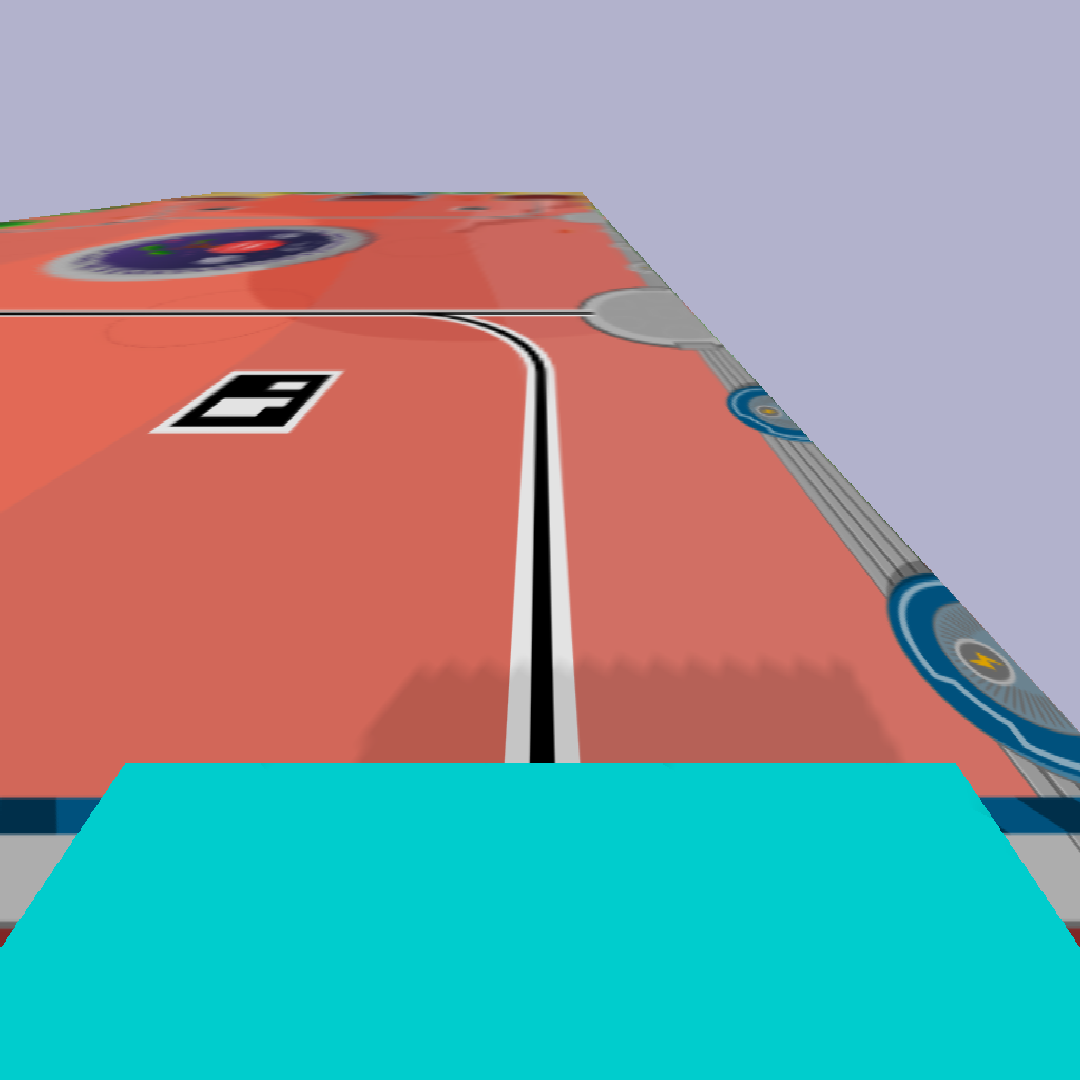

In [14]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "train/ligne_droite/000.png", width = 300, height = 300)

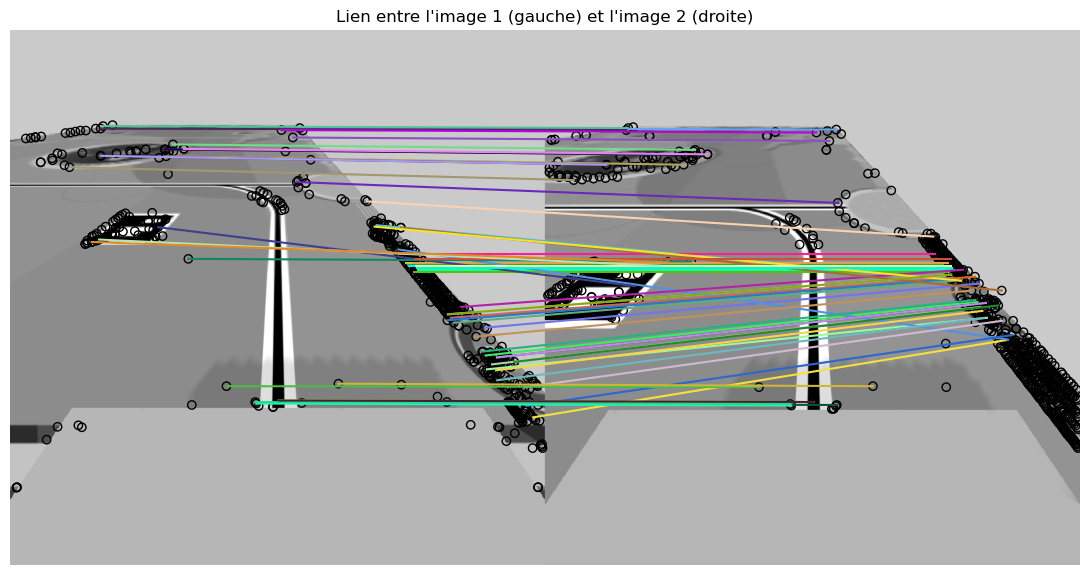

In [15]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT

from PIL import Image

image_0 = Image.open("train/ligne_droite/000.png")
image_1 = Image.open("train/ligne_droite/001.png")

# source https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html
img1 = rgb2gray(np.asarray(image_0))
img2 = rgb2gray(np.asarray(image_1))
tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                                  translation=(0, -200))


descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=0.6,
                              cross_check=True)

fig, ax = plt.subplots(figsize=(11, 8))

plt.gray()

plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Lien entre l'image 1 (gauche) et l'image 2 (droite)")


plt.tight_layout()
plt.show()

## Dessin technique
Le terrain est également muni de Tag Aruco pouvant permettre une triangulation.